In [1]:
# installing dependencies
! pip install transformers datasets --quiet

In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
# reading the training dataset
train_df = pd.read_csv('/kaggle/input/nlpdata/synonymsubstitution_train.csv')
train_df.head()

,headline,label
0,CWG18 ಕುಸ್ತಿಯಲ್ಲಿ ಚಿನ್ನಗಳಿಸಿದ ರಾಹುಲ್ ಅವಾರೆ ಸುಶ...,1
1,CWG18 ಕುಸ್ತಿಯಲ್ಲಿ ರಾಹುಲ್ ಅವೇರ್ ಸುಶೀಲ್ ಕುಮಾರ್ ಚ...,1
2,ರಾಹುಲ್ ಅವೇರ್ ಸುಶೀಲ್ ಕುಮಾರ್ CWG18 ಫೈಟ್‌ಗಳಲ್ಲಿ ಚ...,1
3,ಏಷ್ಯಾ ಕಪ್ 2018 ಪಾಕ್ ವಿರುದ್ಧ ಘರ್ಜಿಸಲು ರೋಹಿತ್ ಸೈ...,1
4,ಏಷ್ಯಾಕಪ್ 2018 ರಲ್ಲಿ ಪಾಕಿಸ್ತಾನದ ವಿರುದ್ಧ ರೋಹಿತ್ ...,1


In [4]:
# reading the testing dataset
test_df = pd.read_csv('/kaggle/input/nlpdata/clean_test.csv')
test_df.head()

,headline,label
0,ಬಜಾರ್ ಅಂಗಳದಲ್ಲಿ ಸಿಕ್ಕ ಧನ್ವೀರ್​,0
1,ಬಿಡುಗಡೆಯಾಯಿತು ಕಿಚ್ಚ ಸುದೀಪ್​ ಕಂಠದಾನ ಮಾಡಿರುವ ಸಿನ...,0
2,"ಸ್ಮಿತ್, ವಾರ್ನರ್​, ಬ್ಯಾಂಕ್ರಾಫ್ಟ್​ಗೆ ಶಿಕ್ಷೆ ಕಡಿತ...",1
3,ಬೆಂಗಳೂರು ಅಂತರ ರಾಷ್ಟ್ರೀಯ ಚಲನಚಿತ್ರೋತ್ಸವದಲ್ಲಿ ಏಷ್...,0
4,ಜಿಯೋ ಭರ್ಜರಿ ಗಿಫ್ಟ್​: ಇಂದಿನಿಂದಲೇ 5 ವರ್ಷಗಳ ಕಾಲ ಉ...,2


In [5]:
# splitting the data into training and validation set
num_of_rows = int(len(train_df) * 0.7)
values = train_df.values
np.random.shuffle(values)
train_df = values[:num_of_rows] 
validation_df = values[num_of_rows:]
train_df = pd.DataFrame(train_df, columns = ['headline', 'label'])
validation_df = pd.DataFrame(validation_df, columns = ['headline', 'label'])
train_df.rename(columns = {'headline': 'text'}, inplace = True)
validation_df.rename(columns = {'headline': 'text'}, inplace = True)
test_df.rename(columns = {'headline': 'text'}, inplace = True)
print(train_df.shape, validation_df.shape, test_df.shape)

(10850, 2) (4651, 2) (1293, 2)


In [6]:
# loading dataset using Dataset Loader
train_df_hg = Dataset(pa.Table.from_pandas(train_df))
validation_df_hg = Dataset(pa.Table.from_pandas(validation_df))
test_df_hg = Dataset(pa.Table.from_pandas(test_df))

In [7]:
# tokenizing datasets using KNU BERT
checkpoint = 'Chakita/KNUBert'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'], truncation = True)

train_df_tokenised = train_df_hg.map(tokenize_function, batched = True)
validation_df_tokenised = validation_df_hg.map(tokenize_function, batched = True)
test_df_tokenised = test_df_hg.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'tf')

  0%|          | 0/11 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
# converting datasets to tensorflow datasets
tf_train_dataset = train_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids'],
    label_cols = ['label'],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_validation_dataset = validation_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_test_dataset = test_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
# loading the model for classification
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, from_pt = True, num_labels = 3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [10]:
# defining hyper parameters
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 0.0, decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [11]:
# compiling the model
model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [12]:
# adding early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5 )

In [13]:
# training the model
history = model.fit(tf_train_dataset, callbacks = early_stopping_callback, validation_data = tf_validation_dataset, epochs = 100, verbose = 2, batch_size = 128)

Epoch 1/100
1356/1356 - 139s - loss: 0.2632 - accuracy: 0.9075 - val_loss: 0.1262 - val_accuracy: 0.9542 - 139s/epoch - 103ms/step
Epoch 2/100
1356/1356 - 96s - loss: 0.0926 - accuracy: 0.9711 - val_loss: 0.1251 - val_accuracy: 0.9596 - 96s/epoch - 71ms/step
Epoch 3/100
1356/1356 - 95s - loss: 0.0521 - accuracy: 0.9833 - val_loss: 0.1419 - val_accuracy: 0.9564 - 95s/epoch - 70ms/step
Epoch 4/100
1356/1356 - 95s - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.1051 - val_accuracy: 0.9684 - 95s/epoch - 70ms/step
Epoch 5/100
1356/1356 - 95s - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.1426 - val_accuracy: 0.9652 - 95s/epoch - 70ms/step
Epoch 6/100
1356/1356 - 88s - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.1111 - val_accuracy: 0.9682 - 88s/epoch - 65ms/step
Epoch 7/100
1356/1356 - 95s - loss: 0.0167 - accuracy: 0.9941 - val_loss: 0.1287 - val_accuracy: 0.9667 - 95s/epoch - 70ms/step
Epoch 8/100
1356/1356 - 95s - loss: 0.0102 - accuracy: 0.9962 - val_loss: 0.1360 - val_accuracy: 0.96

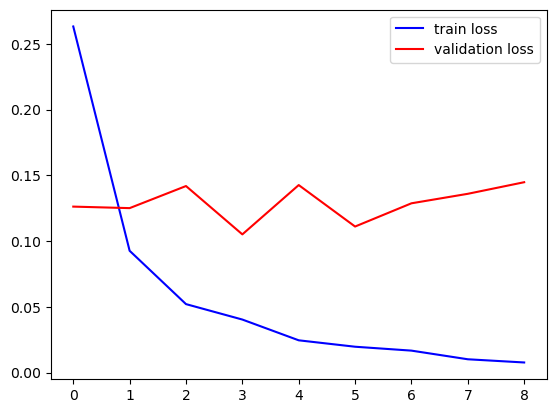

In [14]:
# plotting the loss curve
plt.plot(history.history['loss'], c = 'b', label = 'train loss')
plt.plot(history.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

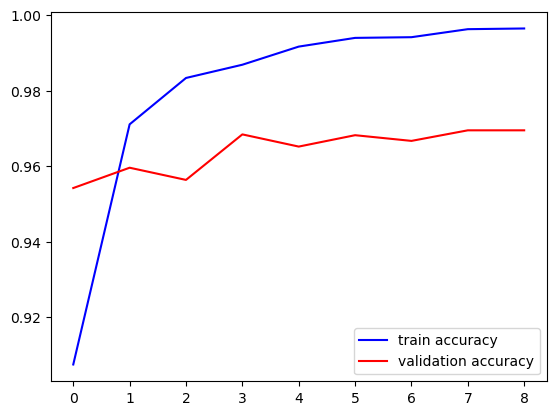

In [15]:
# plotting the accuracy curve
plt.plot(history.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [16]:
# using the trained model to predict the test labels
preds = model.predict(tf_test_dataset)['logits']
class_preds = np.argmax(preds, axis = 1)
print(preds.shape, class_preds.shape)

162/162 [==============================] - 5s 22ms/step
(1293, 3) (1293,)


In [17]:
y_test = test_df.label.values
y_pred = class_preds

In [18]:
# evaluating the predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 95.13%


In [19]:
# printing the classification results
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       661
           1       0.96      0.93      0.95       470
           2       0.93      0.95      0.94       162

    accuracy                           0.95      1293
   macro avg       0.95      0.95      0.95      1293
weighted avg       0.95      0.95      0.95      1293



In [20]:
# printing the confusion matrix for the classification
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[638  15   8]
 [ 28 438   4]
 [  6   2 154]]
